In [179]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
import hashlib

In [245]:
mars = False
base_dir = "./data/lunar/training"
if mars:
    base_dir = "./data/mars/training"

data_dir = "/data/S12_GradeA"
if mars:
    data_dir = "/data"

catalog_file = base_dir + "/catalogs/apollo12_catalog_GradeA_final.csv"
if mars:
    catalog_file = base_dir + "/catalogs/Mars_InSight_training_catalog_final.csv"

catalog = pd.read_csv(catalog_file)
catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [182]:
def max_subarray_sum_with_index(arr, window_width):
    # Create sliding windows
    windows = np.lib.stride_tricks.sliding_window_view(arr, window_width)
    
    # Compute the sum of elements in each window
    window_sums = windows.sum(axis=1)
    
    # Find the index of the maximum sum
    max_index = np.argmax(window_sums)
    
    # Return the starting index of the maximum sum window
    return max_index

----- Reading  xa.s12.00.mhz.1970-01-19HR00_evid00002 0 -----
Arrival time: 73500.0
Predicted Time: 73653.15168925156
----- Reading  xa.s12.00.mhz.1970-03-25HR00_evid00003 1 -----
Arrival time: 12720.0
Predicted Time: 13053.222168888231
----- Reading  xa.s12.00.mhz.1970-03-26HR00_evid00004 2 -----
Arrival time: 73020.0
Predicted Time: 73246.83735184433
----- Reading  xa.s12.00.mhz.1970-04-25HR00_evid00006 3 -----
Arrival time: 4440.0
Predicted Time: 4801.9961156445
----- Reading  xa.s12.00.mhz.1970-04-26HR00_evid00007 4 -----
Arrival time: 52140.0
Predicted Time: 52314.33858878262
----- Reading  xa.s12.00.mhz.1970-06-15HR00_evid00008 5 -----
Arrival time: 68400.0
Predicted Time: 68547.16295831333
----- Reading  xa.s12.00.mhz.1970-06-26HR00_evid00009 6 -----
Arrival time: 72060.0
Predicted Time: 72436.75657792712
----- Reading  xa.s12.00.mhz.1970-07-20HR00_evid00010 7 -----
Arrival time: 18360.0
Predicted Time: 18599.150758778567
----- Reading  xa.s12.00.mhz.1970-07-20HR00_evid00011 8 -

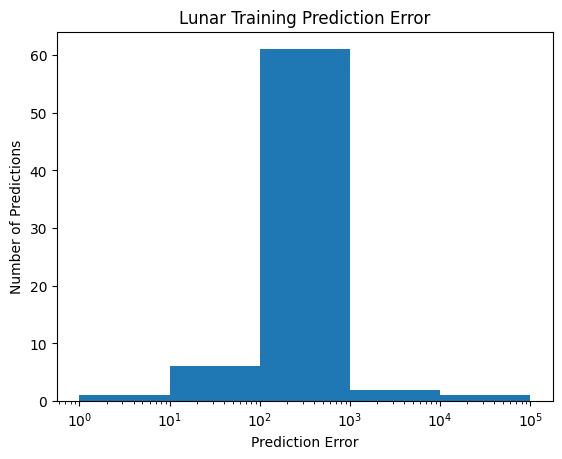

In [248]:
mean_differences = []
window_sizes = [40] # [10 * (i + 1) for i in range(10)]
pairs = []

for window_size in window_sizes:
    hashes = set()
    differences = []
    for idx in range(len(catalog['filename'])):
        row = catalog.iloc[idx]
        filename = row['filename']
        if mars:
            filename = filename[:-4]
        
        print("----- Reading ", filename, idx, "-----")
        # arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
        arrival_time = row['time_rel(sec)']
        mseed_file = f'{base_dir}/{data_dir}/{filename}.mseed'
        st = read(mseed_file)
        
        digest = hashlib.md5(open(mseed_file, 'rb').read()).hexdigest()
        if digest in hashes:
            continue
        hashes.add(digest)
        
        tr = st.traces[0].copy()
        tr_times = tr.times()
        tr_data = tr.data

        print("Arrival time:", arrival_time)

        # Set the minimum frequency
        minfreq = 0.5
        maxfreq = 1.0

        # Going to create a separate trace for the filter data
        st_filt = st.copy()
        st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
        tr_filt = st_filt.traces[0].copy()
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data

        # Start time of trace (another way to get the relative arrival time using datetime)
        f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

        sums = np.sum(sxx, axis=0)
        max_index = max_subarray_sum_with_index(sums, window_size)
        predicted_time = max_index * tr_times_filt[-1] / len(sums)
        print("Predicted Time:", predicted_time)
        differences.append(abs(arrival_time - predicted_time))
        pairs.append((arrival_time, predicted_time))
    differences = np.array(differences)
    if not mars and window_size == 40:
        bins = 10**(np.arange(0, 6))
        plt.xscale('log')
        plt.hist(differences, bins=bins)
        plt.title("Lunar Training Prediction Error")
        plt.xlabel("Prediction Error")
        plt.ylabel("Number of Predictions")
        plt.savefig("./plots/lunar_differences_window_size_40.png")
    elif mars and window_size == 70:
        # bins = 10**(np.arange(0, 6))
        # plt.xscale('log')
        filenames = catalog['filename'].to_list()
        filenames = ["evid" + f.split("_evid")[1].split(".csv")[0] for f in filenames]
        print(filenames)
        plt.bar(filenames, differences)
        plt.title("Mars Training Prediction Error")
        plt.xlabel("Dataset")
        plt.ylabel("Prediction Error")
        plt.savefig("./plots/mars_differences_window_size_40.png")
    mean_differences.append(np.mean(differences))
mean_differences = np.array(mean_differences)
pairs = np.array(pairs)

In [250]:
best_prediction = np.argmin(differences)
best_pair = pairs[best_prediction]

(array([3120.        , 3111.04371008]), 51)

array([289.08418547])

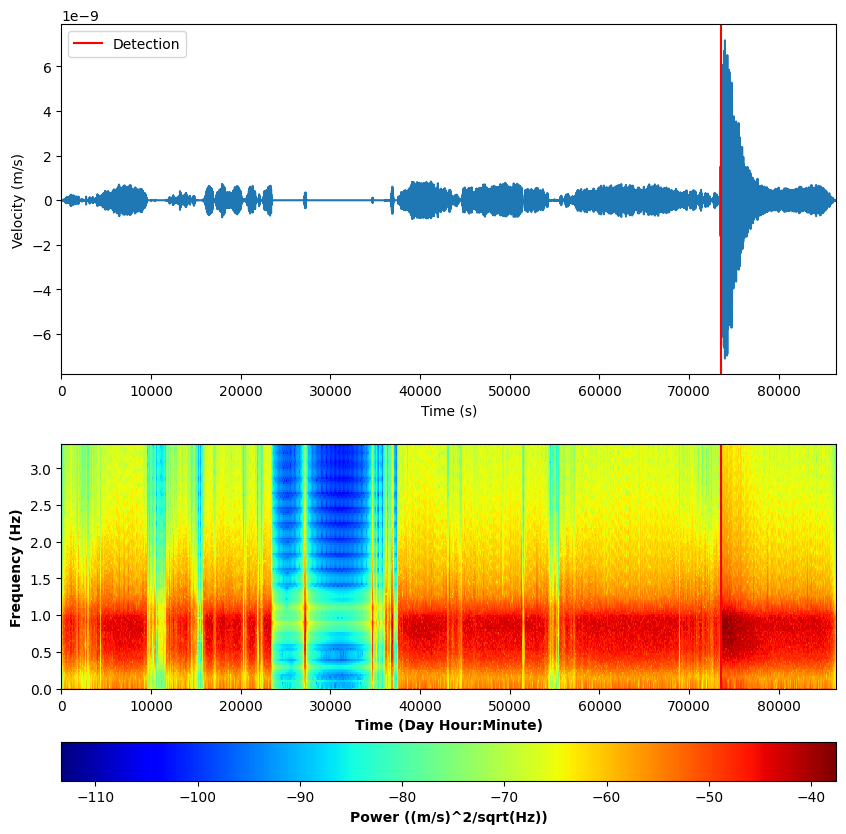

In [131]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

# ax2 = plt.subplot(2, 1, 2)
# vals = ax2.pcolormesh(t, f, np.log(sxx), cmap=cm.jet, vmax=np.log(5e-17))
# ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
# ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
# ax2.axvline(x=arrival, c='red')
# cbar = plt.colorbar(vals, orientation='horizontal')
# cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

In [12]:
    # df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    # sta_len = 120
    # lta_len = 1200

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    # cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    
    # # Play around with the on and off triggers, based on values in the characteristic function
    # thr_on = 4
    # thr_off = 1.5
    # on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    # starttime = tr.stats.starttime.datetime
    # print(len(on_off))